# Initialization and Config


In [ ]:
%load_ext autoreload
%autoreload 2

import torch
from typing import Literal
import gc
import tqdm
import matplotlib.pyplot as plt
from Datasets.coco import CocoDataset
from Datasets.cc12m import CC12mDataset
from Datasets.cood import CoodDataset
from Datasets.laion import LaionDataset
from Models.clip import ClipModel
from Models.clipCaptionModel import ClipCaptionModel
from Models.cloobModel import CLOOBModel
from Models.vClipModel import VariationalCLIPModel
from Models.alignClipModel import AlignCLIPModel

/home/ness/School/Senior/Autonomous/Bulgarian-Burger-CV/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
type Model = Literal['CLIP', 'CLOOB', 'ALIGN', 'VCLIP']
MODEL: Model = 'CLIP'

type Dataset = Literal['COCO', 'COOD', 'CC12M', 'LAION']
DATASET: Dataset = 'COCO'

BATCH_SIZE = 60

DEVICE = None
if torch.cuda.is_available():
    DEVICE = 'cuda'
elif torch.mps.is_available():
    DEVICE = 'mps'
else:
    DEVICE = 'cpu'

TRAIN_RATIO = 0.8
DATA_DIR = '../Data'
TOTAL_DATAPOINTS = 10_000

torch.manual_seed(42)

# Data


In [ ]:
def get_train_val_datasets() -> tuple[torch.utils.data.Dataset, torch.utils.data.Dataset]:
    num_train = int(TOTAL_DATAPOINTS * TRAIN_RATIO)
    num_val = int(TOTAL_DATAPOINTS * (1.0 - TRAIN_RATIO))

    
    if DATASET == 'COCO':
        train = CocoDataset(
            data_dir=DATA_DIR,
            split='train2017',
            tokenize=True,
            max_samples=num_train
        )
        val = CocoDataset(
            data_dir=DATA_DIR,
            split='val2017',
            tokenize=True,
            max_samples=num_val
        )
        return train, val
    
    if DATASET == 'COOD':
        all_data = CoodDataset(
            data_dir=DATA_DIR,
            tokenize=True,
            max_samples=TOTAL_DATAPOINTS
        )
        train = torch.utils.data.Subset(
            all_data,
            range(0, num_train)
        )
        val = torch.utils.data.Subset(
            all_data,
            range(num_train, TOTAL_DATAPOINTS)
        )
        return train, val
    

    if DATASET == 'LAION':
        all_data = LaionDataset(
            tokenize=True,
            max_samples=TOTAL_DATAPOINTS
        )
        train = torch.utils.data.Subset(
            all_data,
            range(0, num_train)
        )
        val = torch.utils.data.Subset(
            all_data,
            range(num_train, TOTAL_DATAPOINTS)
        )
        return train, val

    if DATASET == 'CC12M':
        all_data = CC12mDataset(
            data_dir=DATA_DIR,
            tokenize=True,
            max_samples=TOTAL_DATAPOINTS
        )
        train = torch.utils.data.Subset(
            all_data,
            range(0, num_train)
        )
        val = torch.utils.data.Subset(
            all_data,
            range(num_train, TOTAL_DATAPOINTS)
        )
        return train, val

In [ ]:
def get_train_val_dataloaders() -> tuple[torch.utils.data.DataLoader, torch.utils.data.DataLoader]:
    train, val = get_train_val_datasets()
    train_loader = torch.utils.data.DataLoader(
        train,
        BATCH_SIZE,
        shuffle=True,
        num_workers=0,
        pin_memory=DEVICE == 'cuda'
    )
    val_loader = torch.utils.data.DataLoader(
        val,
        BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        pin_memory=DEVICE == 'cuda'
    )
    return train_loader, val_loader

# Model


In [4]:
def get_model(in_channels: list[int], bottleneck_channels: int, dropout_prob: float | list[float], use_residual: bool) -> UNet:
    return UNet(
        channel_sizes=in_channels,
        bottleneck_channels=bottleneck_channels,
        dropout_prob=dropout_prob,
        act=ACTIVATION,
        use_residual=use_residual
    ).to(DEVICE)

In [5]:
def get_optimizer(model: UNet, lr: float) -> torch.optim.Optimizer:
    return torch.optim.Adam(model.parameters(), lr=lr)


def get_scheduler(optimizer: torch.optim.Optimizer, step_size: int, gamma: float) -> torch.optim.lr_scheduler.StepLR:
    return torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)


loss = UNetLoss()

# Training


In [6]:
def train_epoch(model: UNet, dataloader: torch.utils.data.DataLoader, optimizer: torch.optim.Optimizer, criterion: torch.nn.Module, scheduler: torch.optim.lr_scheduler.LRScheduler):
    model.train()

    progress_bar = tqdm.tqdm(dataloader, desc="Training Epoch")

    running_loss = 0.0
    for batchIdx, (images, masks) in enumerate(progress_bar):
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        outputs = model(images)
        loss = criterion(outputs, masks)
        running_loss += loss.item()
        progress_bar.set_postfix(
            {'Avg Epoch Loss': loss.item() / (batchIdx + 1)})

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        torch.cuda.empty_cache()
        gc.collect()

    scheduler.step()
    epoch_loss = running_loss / len(dataloader)

    return epoch_loss


def evaluate(model: UNet, dataloader: torch.utils.data.DataLoader, criterion: torch.nn.Module):
    model.eval()

    total_loss = 0.0
    total_acc = 0.0
    total_pr = 0.0
    total_re = 0.0

    progress_bar = tqdm.tqdm(dataloader, desc="Evaluating")

    with torch.no_grad():
        for batchIdx, (images, masks) in enumerate(progress_bar):
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, masks)

            total_loss += loss.item()
            batch_acc = torchmetrics.functional.accuracy(
                outputs, masks, task="binary", average="macro")
            batch_pr = torchmetrics.functional.precision(
                outputs, masks, task="binary", average="macro")
            batch_re = torchmetrics.functional.recall(
                outputs, masks, task="binary", average="macro")
            total_acc += batch_acc.item()
            total_pr += batch_pr.item()
            total_re += batch_re.item()

            progress_bar.set_postfix({
                'Avg Eval Loss': total_loss / (batchIdx + 1),
                'Batch Acc': total_acc / (batchIdx + 1),
                'Batch Precision': total_pr / (batchIdx + 1),
                'Batch Recall': total_re / (batchIdx + 1)
            })

            torch.cuda.empty_cache()
            gc.collect()

    avg_loss = total_loss / len(dataloader)  # type: ignore

    return avg_loss


def train_and_eval(model: UNet, dataloader_train: torch.utils.data.DataLoader, dataloader_test: torch.utils.data.DataLoader, optimizer: torch.optim.Optimizer, criterion: torch.nn.Module, scheduler: torch.optim.lr_scheduler.LRScheduler, num_epochs: int, save=False):
    model.train()
    
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        train_loss = train_epoch(
            model, dataloader_train, optimizer, criterion, scheduler)
        val_loss = evaluate(model, dataloader_test, criterion)
        print(
            f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        print("Learning Rate:", scheduler.get_last_lr())

        if save and val_loss < best_val_loss:
            best_val_loss = val_loss
            model_name = f'saved/{MODEL_NAME}.pth'
            torch.save(model.state_dict(), model_name)
            print('Model saved!')

    return train_loss, val_loss

# Eval


In [7]:
def N_fold_cross_validation(fold_size: int, num_epochs: int, dataset: ImageDataset, get_model, get_optimizer, get_scheduler):
    numFolds = len(dataset) // fold_size

    cross_loss = 0
    for fold in range(numFolds):
        foldStart = fold * fold_size
        foldEnd = foldStart + fold_size

        evalSubset = torch.utils.data.Subset(
            dataset, list(range(foldStart, foldEnd)))
        trainSubset = torch.utils.data.Subset(dataset, list(
            range(0, foldStart)) + list(range(foldEnd, len(dataset))))
        trainLoader = torch.utils.data.DataLoader(
            trainSubset, batch_size=4, shuffle=True)

        print(f'Fold {fold+1}/{numFolds}: Starting training...')
        model = get_model()
        optimizer = get_optimizer(model)
        scheduler = get_scheduler(optimizer)
        for _ in range(num_epochs):
            train_epoch(model, trainLoader, optimizer, loss, scheduler)
        print(f'Fold {fold+1}/{numFolds}: Evaluating...')
        cross_loss += evaluate(model, torch.utils.data.DataLoader(evalSubset, batch_size=BATCH_SIZE), loss)

    print(f'Average Cross-Validation Loss: {cross_loss / numFolds:.4f}')
    return cross_loss / numFolds

# Tuning


In [8]:
def objective_function(trial: optuna.Trial):
    color_space: Literal['RGB', 'LAB'] = trial.suggest_categorical(
        'color_space', ['RGB', 'LAB'])  # type: ignore
    use_residual: bool = True
    starting_channels = trial.suggest_int('starting_channels', 64, 100, step=1)
    in_channels = [
        3,
        starting_channels,
        starting_channels * 2,
        starting_channels * 4
    ]
    bottleneck_channels = starting_channels * 8

    final_loss = N_fold_cross_validation(
        fold_size=5,
        num_epochs=5,
        dataset=ImageDataset('../images', '../masks', 'test', TASK, image_space=color_space),
        get_model=lambda: get_model(
            in_channels, bottleneck_channels, 0.30, use_residual),
        get_optimizer=lambda model: get_optimizer(
            model, lr=0.000918172943558147
        ),
        get_scheduler=lambda optimizer: get_scheduler(
            optimizer, step_size=2, gamma=0.8
        )
    )

    return final_loss

# Run Tuning


In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective_function, n_trials=15)

print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')

for key, value in trial.params.items():
    print(f'    {key}: {value}')

# Run Training


In [ ]:
start_channels = START_CHANNELS
model = get_model(
    in_channels=[
        3,
        start_channels,
        start_channels * 2,
        start_channels * 4
    ],
    bottleneck_channels=start_channels * 8,
    dropout_prob=0.3,
    use_residual=True
)
optimizer = get_optimizer(model, lr=0.000918172943558147)
scheduler = get_scheduler(optimizer, step_size=5, gamma=0.5)
dataloader_train = get_dataset(IMAGE_SPACE, 'train')
dataloader_test = get_dataset(IMAGE_SPACE, 'test')

torch.cuda.empty_cache()
gc.collect()
torchinfo.summary(model, input_size=(1, 3, 3280, 2464))

Layer (type:depth-idx)                        Output Shape              Param #
UNet                                          [1, 1, 3280, 2464]        --
├─ModuleList: 1-1                             --                        --
│    └─DownsampleBlock: 2-1                   [1, 24, 1640, 1232]       --
│    │    └─Sequential: 3-1                   [1, 24, 3280, 2464]       5,976
│    │    └─Conv2d: 3-2                       [1, 24, 1640, 1232]       2,328
│    │    └─Sequential: 3-3                   [1, 24, 1640, 1232]       360
│    └─DownsampleBlock: 2-2                   [1, 48, 820, 616]         --
│    │    └─Sequential: 3-4                   [1, 48, 1640, 1232]       31,392
│    │    └─Conv2d: 3-5                       [1, 48, 820, 616]         9,264
│    │    └─Sequential: 3-6                   [1, 48, 820, 616]         4,752
│    └─DownsampleBlock: 2-3                   [1, 96, 410, 308]         --
│    │    └─Sequential: 3-7                   [1, 96, 820, 616]         124,99

In [ ]:
torch.cuda.empty_cache()
gc.collect()
train_and_eval(
    model,
    dataloader_train,
    dataloader_test,
    optimizer,
    loss,
    scheduler,
    num_epochs=20,
    save=True
)

Evaluating: 100%|██████████| 9/9 [00:02<00:00,  3.21it/s, Avg Eval Loss=3.54, Batch Acc=0.92, Batch Precision=0.596, Batch Recall=0.953] 


Epoch 1/20, Train Loss: 1.1504, Val Loss: 3.5372
Learning Rate: [0.003918172943558147]
Model saved!


Evaluating: 100%|██████████| 9/9 [00:02<00:00,  3.28it/s, Avg Eval Loss=0.395, Batch Acc=0.966, Batch Precision=0.865, Batch Recall=0.849]


Epoch 2/20, Train Loss: 0.8904, Val Loss: 0.3946
Learning Rate: [0.003918172943558147]
Model saved!


Evaluating: 100%|██████████| 9/9 [00:02<00:00,  3.28it/s, Avg Eval Loss=0.374, Batch Acc=0.967, Batch Precision=0.893, Batch Recall=0.829]


Epoch 3/20, Train Loss: 0.7749, Val Loss: 0.3736
Learning Rate: [0.003918172943558147]
Model saved!


Evaluating: 100%|██████████| 9/9 [00:02<00:00,  3.28it/s, Avg Eval Loss=0.368, Batch Acc=0.968, Batch Precision=0.905, Batch Recall=0.834]


Epoch 4/20, Train Loss: 0.8741, Val Loss: 0.3682
Learning Rate: [0.003918172943558147]
Model saved!


Evaluating: 100%|██████████| 9/9 [00:02<00:00,  3.31it/s, Avg Eval Loss=0.349, Batch Acc=0.966, Batch Precision=0.88, Batch Recall=0.829] 


Epoch 5/20, Train Loss: 0.7454, Val Loss: 0.3488
Learning Rate: [0.0019590864717790733]
Model saved!


Evaluating: 100%|██████████| 9/9 [00:04<00:00,  2.24it/s, Avg Eval Loss=0.316, Batch Acc=0.97, Batch Precision=0.913, Batch Recall=0.842] 


Epoch 6/20, Train Loss: 0.7543, Val Loss: 0.3161
Learning Rate: [0.0019590864717790733]
Model saved!


Evaluating: 100%|██████████| 9/9 [00:03<00:00,  2.46it/s, Avg Eval Loss=0.305, Batch Acc=0.973, Batch Precision=0.916, Batch Recall=0.862]


Epoch 7/20, Train Loss: 0.6330, Val Loss: 0.3051
Learning Rate: [0.0019590864717790733]
Model saved!


Evaluating: 100%|██████████| 9/9 [00:03<00:00,  2.44it/s, Avg Eval Loss=0.303, Batch Acc=0.97, Batch Precision=0.864, Batch Recall=0.884] 


Epoch 8/20, Train Loss: 0.5760, Val Loss: 0.3031
Learning Rate: [0.0019590864717790733]
Model saved!


Training Epoch:   8%|▊         | 2/26 [00:02<00:19,  1.23it/s, Avg Epoch Loss=0.0945]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x776884efb8c0>>
Traceback (most recent call last):
  File "/home/ness/School/Senior/Autonomous/Bulgarian-Burger-CV/.venv/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 797, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Training Epoch:  46%|████▌     | 12/26 [00:13<00:16,  1.20s/it, Avg Epoch Loss=0.0992]

# Run Eval


In [19]:
start_channels = START_CHANNELS
model = get_model(
    in_channels=[
        3,
        start_channels,
        start_channels * 2,
        start_channels * 4
    ],
    bottleneck_channels=start_channels * 8,
    dropout_prob=0.3,
    use_residual=True
)
model.load_state_dict(torch.load(f'saved/{MODEL_NAME}.pth'))
dataloader = get_dataset(IMAGE_SPACE, 'test')
evaluate(model, dataloader, loss)

Evaluating: 100%|██████████| 11/11 [00:35<00:00,  3.22s/it, Avg Eval Loss=0.0826, Batch Acc=0.984, Batch Precision=0.417, Batch Recall=0.0798]


0.0825623067265207

# Run Visualization

In [11]:

start_channels = START_CHANNELS
model = get_model(
    in_channels=[
        3,
        start_channels,
        start_channels * 2,
        start_channels * 4
    ],
    bottleneck_channels=start_channels * 8,
    dropout_prob=0.3,
    use_residual=True
)
model.load_state_dict(torch.load(f'saved/{MODEL_NAME}.pth'))
model.eval()

dataset = ImageDataset('../images', '../masks', 'train', TASK, image_space=IMAGE_SPACE)
image, mask = dataset[0]
out_mask = model(image.unsqueeze(0).to(DEVICE)).squeeze(0).cpu()

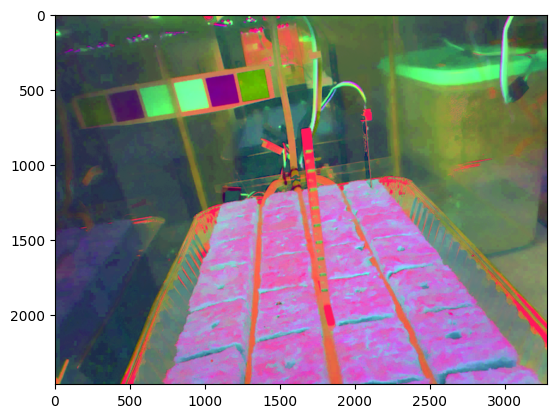

In [12]:
plt.imshow(denorm_image(image).permute(1, 2, 0).numpy())
plt.show()

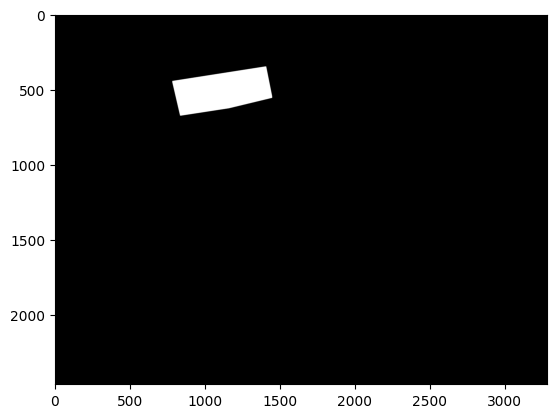

In [13]:
plt.imshow(mask.squeeze(0).numpy(), cmap='gray')
plt.show()

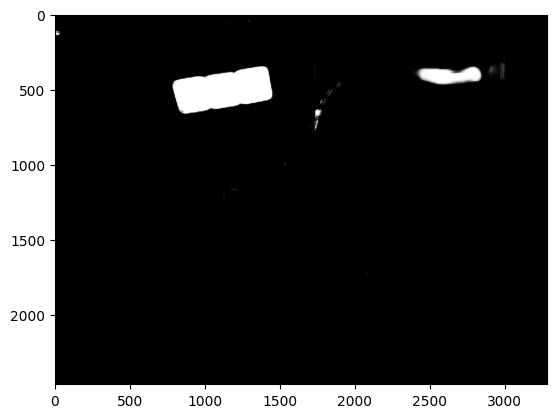

In [14]:
plt.imshow(out_mask.detach().squeeze(0).numpy(), cmap='gray')
plt.show()

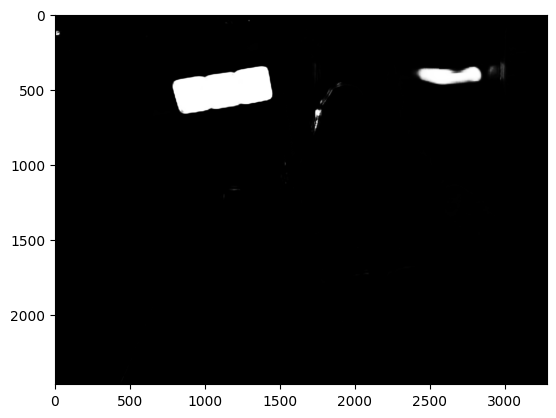

In [15]:
plt.imshow(torch.nn.functional.sigmoid(out_mask).detach().squeeze(0).numpy(), cmap='gray')
plt.show()

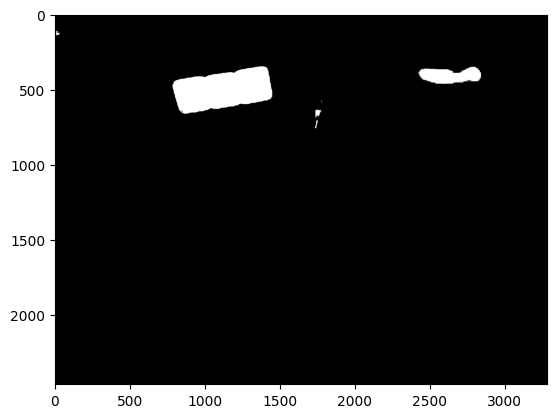

In [16]:
plt.imshow(postprocess_mask(out_mask.detach()), cmap='gray')
plt.show()

# Export Onnx

In [9]:
start_channels = START_CHANNELS
model = get_model(
    in_channels=[
        3,
        start_channels,
        start_channels * 2,
        start_channels * 4
    ],
    bottleneck_channels=start_channels * 8,
    dropout_prob=0.0,
    use_residual=True
)
model.load_state_dict(torch.load(f'saved/{MODEL_NAME}.pth'))
model.eval()

torch.onnx.export(
    model.to('cpu'),
      (torch.randn(1, 3, IMAGE_WIDTH, IMAGE_HEIGHT),),
    f'saved/{MODEL_NAME}.onnx',
    export_params=True,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'], 
)


[torch.onnx] Obtain model graph for `UNet([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `UNet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 20 of general pattern rewrite rules.


ONNXProgram(
    model=
        <
            ir_version=10,
            opset_imports={'': 20},
            producer_name='pytorch',
            producer_version='2.9.0+cu128',
            domain=None,
            model_version=None,
        >
        graph(
            name=main_graph,
            inputs=(
                %"input"<FLOAT,[1,3,2464,3280]>
            ),
            outputs=(
                %"output"<FLOAT,[1,1,2464,3280]>
            ),
            initializers=(
                %"bottleneck.0.weight"<FLOAT,[192,96,3,3]>{Tensor(...)},
                %"bottleneck.0.bias"<FLOAT,[192]>{Tensor(...)},
                %"bottleneck.3.weight"<FLOAT,[192,192,3,3]>{Tensor(...)},
                %"bottleneck.3.bias"<FLOAT,[192]>{Tensor(...)},
                %"final_layer.weight"<FLOAT,[1,24,1,1]>{TorchTensor(...)},
                %"final_layer.bias"<FLOAT,[1]>{TorchTensor<FLOAT,[1]>(Parameter containing: tensor([-0.1820], requires_grad=True), name='final_layer.bias')},
      